In [1]:
import sys
import os

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from features.get_merged_dataframes import get_merged_dataframes

In [2]:
pair_1, pair_2 = "BTC_USDT", "DOT_USDT"

In [3]:
train_df, val_df, test_df = get_merged_dataframes(pair_1, pair_2)

start: 2020-08-18 23:00:00+00:00, end: 2025-04-09 17:54:00+00:00


In [5]:
df = train_df.copy()

Computed class weights: [0.6639834054238807, 2.02454450713336]
0:	test: 0.5456999	best: 0.5456999 (0)	total: 340ms	remaining: 5m 39s
100:	test: 0.6196982	best: 0.6196982 (100)	total: 32.1s	remaining: 4m 45s
200:	test: 0.6430957	best: 0.6430957 (200)	total: 1m 2s	remaining: 4m 6s
300:	test: 0.6536686	best: 0.6536686 (300)	total: 1m 27s	remaining: 3m 23s
400:	test: 0.6578735	best: 0.6579293 (399)	total: 1m 54s	remaining: 2m 51s
500:	test: 0.6583062	best: 0.6589442 (471)	total: 2m 22s	remaining: 2m 21s
600:	test: 0.6593237	best: 0.6594030 (599)	total: 2m 49s	remaining: 1m 52s
700:	test: 0.6609942	best: 0.6610783 (685)	total: 3m 16s	remaining: 1m 23s
800:	test: 0.6613850	best: 0.6618291 (753)	total: 3m 43s	remaining: 55.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6618291009
bestIteration = 753

Shrink model to first 754 iterations.
Test AUC: 0.6618


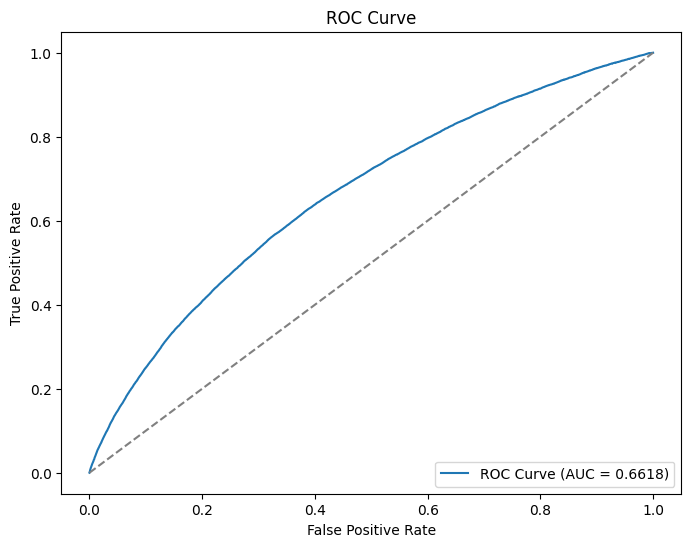

Optimal Threshold: 0.4768813370994699
Adjusted Test Accuracy: 0.6146870879399533

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.90      0.61      0.73    166062
           1       0.23      0.63      0.34     31118

    accuracy                           0.61    197180
   macro avg       0.57      0.62      0.53    197180
weighted avg       0.79      0.61      0.67    197180

Percentage of predicted growth (2*fee) that is incorrect: 65.22%
Ratio of actual growth events correctly predicted: 12.29%

Top 20 Feature Importances:
               feature  importance
69            volume_y   12.568311
100       MOM_ATR_ST_y   10.515854
112     BOL_width_ST_y    5.717806
101       MOM_ATR_MT_y    5.067771
70   RAW_prev_return_y    4.097301
102       MOM_ATR_LT_y    3.351738
116     BOL_width_MT_y    2.756000
88    OSC_STOCH_K_ST_y    2.010107
122       VOL_ADL_MT_y    1.854828
106       MOM_ROC_ST_y    1.560231
5    RAW_p

In [16]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# --------------------------
# User defined fee parameter
# --------------------------
fee = 5  # example fee in basis points
threshold = (2 * fee) / 10000  # Convert 2*fee basis points into decimal return (e.g., 10 bps -> 0.001)

# --------------------------
# Data Preparation
# --------------------------
# Assume your DataFrame 'df' contains ~100 technical indicators including 'close_y'
# Create the target variable:
#   1 if the next return exceeds the threshold (2 * fee basis points), otherwise 0.
df['target'] = ((df['close_y'].shift(-1) / df['close_y'] - 1) > threshold).astype(int)

# Drop the last row which has an undefined target (NaN value)
df.dropna(inplace=True)

# Define features: exclude 'close_y' (price) and the target variable
features = [col for col in df.columns if col not in ['date', 'target']]
X = df[features]
y = df['target']

# --------------------------
# Train / Test Split (Time Order)
# --------------------------
# For time series data, maintain the order to prevent lookahead bias.
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Create CatBoost Pool objects for efficient data handling
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# --------------------------
# Compute Balanced Class Weights
# --------------------------
# This helps if the classes (i.e. returns above threshold vs. not) are imbalanced.
classes = np.unique(y_train)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = [weights[int(c)] for c in classes]
print('Computed class weights:', class_weights)

# --------------------------
# Model Initialization and Training
# --------------------------
# You can adjust hyperparameters as needed.
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    od_type='Iter',
    od_wait=100,
    class_weights=class_weights
    # If using a GPU, you can include: task_type='GPU'
)

model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=100,
    verbose=100
)

# --------------------------
# Evaluation: ROC Curve & Optimal Threshold Tuning
# --------------------------
# Predict probabilities for the positive class (next return above threshold)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for performance evaluation
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print('Test AUC: {:.4f}'.format(roc_auc))

# Plot ROC curve for visual evaluation
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute Youden's J statistic (tpr - fpr) and select the optimal threshold
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

# Convert probabilities to binary predictions using the optimal threshold
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# --------------------------
# Final Evaluation
# --------------------------
accuracy = accuracy_score(y_test, y_pred_adjusted)
print("Adjusted Test Accuracy:", accuracy)
print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y_test, y_pred_adjusted))

# --------------------------
# Print Additional Metrics: Incorrect and Correct Predictions for Growth (class 1)
# --------------------------
# Count true positives (TP), false positives (FP), false negatives (FN)
TP = np.sum((y_pred_final == 1) & (y_test == 1))
FP = np.sum((y_pred_final == 1) & (y_test == 0))
predicted_positives = np.sum(y_pred_final == 1)
actual_positives = np.sum(y_test == 1)

if predicted_positives > 0:
    pct_incorrect_growth = (FP / predicted_positives) * 100
else:
    pct_incorrect_growth = float('nan')

if actual_positives > 0:
    ratio_correctly_predicted_growth = (TP / actual_positives) * 100
else:
    ratio_correctly_predicted_growth = float('nan')

print(f"Percentage of predicted growth (2*fee) that is incorrect: {pct_incorrect_growth:.2f}%")
print(f"Ratio of actual growth events correctly predicted: {ratio_correctly_predicted_growth:.2f}%")

# --------------------------
# Feature Importance Analysis (Optional)
# --------------------------
feature_importances = model.get_feature_importance(train_pool)
feat_imp_df = pd.DataFrame({
    'feature': X_train.columns, 
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("\nTop 20 Feature Importances:")
print(feat_imp_df.head(20))

Using manual class weights: [1, 0.75]
0:	test: 0.5390709	best: 0.5390709 (0)	total: 292ms	remaining: 4m 52s
100:	test: 0.6132219	best: 0.6317144 (10)	total: 30.4s	remaining: 4m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6317144463
bestIteration = 10

Shrink model to first 11 iterations.
Test AUC: 0.6317


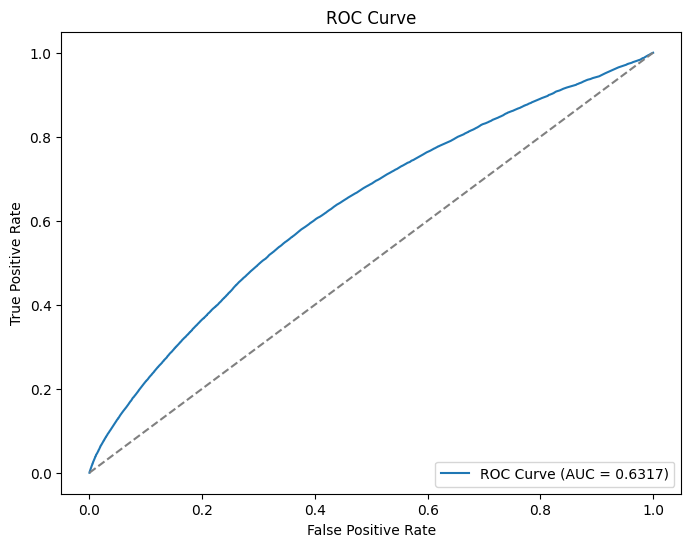

In [10]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

fee = 5
threshold_return = (2 * fee) / 10000

df['target'] = ((df['close_y'].shift(-1) / df['close_y'] - 1) > threshold_return).astype(int)
df.dropna(inplace=True)

features = [col for col in df.columns if col not in ['date', 'target']]
X = df[features]
y = df['target']

train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

manual_class_weights = [1, 0.75]
print("Using manual class weights:", manual_class_weights)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.005,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    od_type='Iter',
    od_wait=100,
    class_weights=manual_class_weights
)

model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=100,
    verbose=100
)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print('Test AUC: {:.4f}'.format(roc_auc))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [18]:
print("Threshold analysis for class 1 (buy signal):")
for thresh in np.linspace(0.4, 1.0, 13):
    y_pred_adj = (y_pred_proba >= thresh).astype(int)
    report = classification_report(y_test, y_pred_adj, output_dict=True)
    pos_precision = report['1']['precision']
    pos_recall = report['1']['recall']
    print(f"Threshold: {thresh:.2f} -> Class 1 Precision: {pos_precision:.3f}, Recall: {pos_recall:.3f}")

selected_threshold = 0.7
print("Selected threshold for predicting a buy signal (class 1):", selected_threshold)
y_pred_adjusted = (y_pred_proba >= selected_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_adjusted)
print("Adjusted Test Accuracy:", accuracy)
print("\nClassification Report (with Selected Threshold):")
print(classification_report(y_test, y_pred_adjusted))

# --------------------------
# Print Additional Metrics: Incorrect and Correct Predictions for Growth (class 1)
# --------------------------
# Count true positives (TP), false positives (FP), false negatives (FN)
TP = np.sum((y_pred_final == 1) & (y_test == 1))
FP = np.sum((y_pred_final == 1) & (y_test == 0))
predicted_positives = np.sum(y_pred_final == 1)
actual_positives = np.sum(y_test == 1)

if predicted_positives > 0:
    pct_incorrect_growth = (FP / predicted_positives) * 100
else:
    pct_incorrect_growth = float('nan')

if actual_positives > 0:
    ratio_correctly_predicted_growth = (TP / actual_positives) * 100
else:
    ratio_correctly_predicted_growth = float('nan')

print(f"Percentage of predicted growth (2*fee) that is incorrect: {pct_incorrect_growth:.2f}%")
print(f"Ratio of actual growth events correctly predicted: {ratio_correctly_predicted_growth:.2f}%")

feature_importances = model.get_feature_importance(train_pool)
feat_imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print("\nTop 20 Feature Importances:")
print(feat_imp_df.head(20))

Threshold analysis for class 1 (buy signal):
Threshold: 0.40 -> Class 1 Precision: 0.425, Recall: 0.024
Threshold: 0.45 -> Class 1 Precision: 0.000, Recall: 0.000


/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Threshold: 0.50 -> Class 1 Precision: 0.000, Recall: 0.000
Threshold: 0.55 -> Class 1 Precision: 0.000, Recall: 0.000
Threshold: 0.60 -> Class 1 Precision: 0.000, Recall: 0.000


/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Threshold: 0.65 -> Class 1 Precision: 0.000, Recall: 0.000
Threshold: 0.70 -> Class 1 Precision: 0.000, Recall: 0.000
Threshold: 0.75 -> Class 1 Precision: 0.000, Recall: 0.000


/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Threshold: 0.80 -> Class 1 Precision: 0.000, Recall: 0.000
Threshold: 0.85 -> Class 1 Precision: 0.000, Recall: 0.000
Threshold: 0.90 -> Class 1 Precision: 0.000, Recall: 0.000


/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Threshold: 0.95 -> Class 1 Precision: 0.000, Recall: 0.000
Threshold: 1.00 -> Class 1 Precision: 0.000, Recall: 0.000
Selected threshold for predicting a buy signal (class 1): 0.7
Adjusted Test Accuracy: 0.8421848057612334

Classification Report (with Selected Threshold):
              precision    recall  f1-score   support

           0       0.84      1.00      0.91    166062
           1       0.00      0.00      0.00     31118

    accuracy                           0.84    197180
   macro avg       0.42      0.50      0.46    197180
weighted avg       0.71      0.84      0.77    197180

Percentage of predicted growth (2*fee) that is incorrect: 84.22%
Ratio of actual growth events correctly predicted: 100.00%


/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shatar/DiplomaPublic/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


Top 20 Feature Importances:
                feature  importance
69             volume_y   27.828006
101        MOM_ATR_MT_y    5.993730
100        MOM_ATR_ST_y    4.499539
116      BOL_width_MT_y    4.106511
112      BOL_width_ST_y    4.027791
102        MOM_ATR_LT_y    3.858234
35         MOM_ATR_ST_x    3.709105
120      BOL_width_LT_y    2.935540
106        MOM_ROC_ST_y    1.928138
9     MA_SMA_daily_LT_x    1.773804
4              volume_x    1.760455
49   BOL_BB_MIDDLE_MT_x    1.626387
48    BOL_BB_UPPER_MT_x    1.618994
47       BOL_width_ST_x    1.516092
36         MOM_ATR_MT_x    1.422979
55       BOL_width_LT_x    1.415616
107        MOM_ROC_MT_y    1.369755
6           MA_SMA_ST_x    1.294021
70    RAW_prev_return_y    1.179248
37         MOM_ATR_LT_x    1.160575


Using manual class weights: [1, 0.5]
0:	test: 0.5105657	best: 0.5105657 (0)	total: 390ms	remaining: 3m 14s
100:	test: 0.6128030	best: 0.6162519 (68)	total: 28.7s	remaining: 1m 53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6162519085
bestIteration = 68

Shrink model to first 69 iterations.
Test ROC AUC: 0.6163


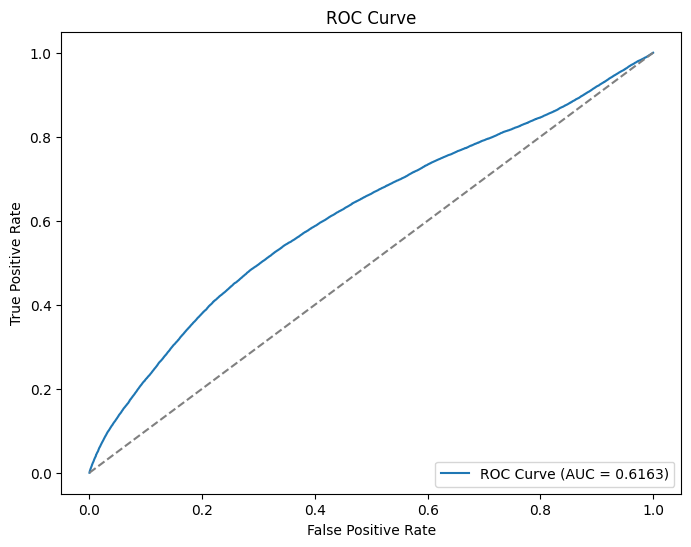

Threshold analysis (F0.5 score optimization):
Threshold: 0.10 -> Precision: 0.158, Recall: 1.000, F0.5: 0.190
Threshold: 0.15 -> Precision: 0.158, Recall: 1.000, F0.5: 0.190
Threshold: 0.20 -> Precision: 0.158, Recall: 1.000, F0.5: 0.190
Threshold: 0.25 -> Precision: 0.158, Recall: 1.000, F0.5: 0.190
Threshold: 0.30 -> Precision: 0.158, Recall: 1.000, F0.5: 0.190
Threshold: 0.35 -> Precision: 0.158, Recall: 1.000, F0.5: 0.190
Threshold: 0.40 -> Precision: 0.425, Recall: 0.024, F0.5: 0.098
Selected threshold based on F0.5 score: 0.10 (Precision: 0.158, Recall: 1.000, F0.5: 0.190)
Final Test Accuracy: 0.1578151942387666

Final Classification Report (using threshold 0.10):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    166062
           1       0.16      1.00      0.27     31118

    accuracy                           0.16    197180
   macro avg       0.08      0.50      0.14    197180
weighted avg       0.02      0.16      0.04    19

In [19]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, fbeta_score
import matplotlib.pyplot as plt

# --------------------------
# Parameters and Threshold Conversion
# --------------------------
fee = 5  # fee in basis points
threshold_return = (2 * fee) / 10000  # For fee=5, threshold_return = 0.001

# --------------------------
# Data Preparation
# --------------------------
# Assume df is your DataFrame with technical indicators and a 'close_y' column.
# Create a binary target: 1 if next return > threshold_return, else 0.
df['target'] = ((df['close_y'].shift(-1) / df['close_y'] - 1) > threshold_return).astype(int)
df.dropna(inplace=True)  # remove the last row (undefined target)

# Select features (exclude raw price and target)
features = [col for col in df.columns if col not in ['date', 'target']]
X = df[features]
y = df['target']

# --------------------------
# Train/Test Split (Time-Ordered)
# --------------------------
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size].copy(), X.iloc[train_size:].copy()
y_train, y_test = y.iloc[:train_size].copy(), y.iloc[train_size:].copy()

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# --------------------------
# Adjust Class Weights to Discourage False Positives
# --------------------------
# Instead of computed weights, we choose to penalize positives heavier.
# Here, negative:positive weight is [1, 0.5]. (You may adjust this further.)
manual_class_weights = [1, 0.5]
print("Using manual class weights:", manual_class_weights)

# --------------------------
# Model Initialization and Training
# --------------------------
# Increase iterations and lower learning rate to allow the model to learn more gradually.
model = CatBoostClassifier(
    iterations=500,               # Allow up to 500 iterations
    learning_rate=0.005,          # Lower learning rate for gradual learning
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    od_type='Iter',
    od_wait=50,                   # Increase early stopping patience
    class_weights=manual_class_weights
    # If using GPU, uncomment the next line:
    # task_type='GPU'
)

model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=50,
    verbose=100
)

# --------------------------
# Model Evaluation: ROC & AUC
# --------------------------
# Predict probabilities for class 1 (buy signal)
y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)
print('Test ROC AUC: {:.4f}'.format(roc_auc_value))

# (Optional) Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# --------------------------
# Threshold Tuning Focusing on High Precision (Using F0.5 Score)
# --------------------------
# We wish to prioritize precision (to avoid false buy signals).
# Compute F0.5 score for candidate thresholds and select the best.
beta = 0.5  # F0.5 gives more weight to precision
candidates = np.arange(0.1, 1.0, 0.05)
results = []

print("Threshold analysis (F0.5 score optimization):")
for thresh in candidates:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    # Ensure we have at least one predicted positive to compute meaningful scores.
    if np.sum(y_pred_thresh) == 0:
        # If no positives, skip the threshold.
        continue
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh, zero_division=0)
    f05 = fbeta_score(y_test, y_pred_thresh, beta=beta, zero_division=0)
    results.append((thresh, prec, rec, f05))
    print(f"Threshold: {thresh:.2f} -> Precision: {prec:.3f}, Recall: {rec:.3f}, F0.5: {f05:.3f}")

# Choose the threshold that maximizes F0.5 among candidates that yield any positives.
if results:
    best_thresh, best_prec, best_rec, best_f05 = max(results, key=lambda x: x[3])
    print(f"Selected threshold based on F0.5 score: {best_thresh:.2f} "
          f"(Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F0.5: {best_f05:.3f})")
else:
    best_thresh = 0.5
    print("No candidate threshold produced any positives; default to 0.5.")

# Generate final predictions using the selected threshold.
y_pred_final = (y_pred_proba >= best_thresh).astype(int)

# --------------------------
# Final Evaluation and Report
# --------------------------
accuracy = accuracy_score(y_test, y_pred_final)
print("Final Test Accuracy:", accuracy)
print("\nFinal Classification Report (using threshold {:.2f}):".format(best_thresh))
print(classification_report(y_test, y_pred_final, zero_division=0))

# --------------------------
# Print Additional Metrics: Incorrect and Correct Predictions for Growth (class 1)
# --------------------------
# Count true positives (TP), false positives (FP), false negatives (FN)
TP = np.sum((y_pred_final == 1) & (y_test == 1))
FP = np.sum((y_pred_final == 1) & (y_test == 0))
predicted_positives = np.sum(y_pred_final == 1)
actual_positives = np.sum(y_test == 1)

if predicted_positives > 0:
    pct_incorrect_growth = (FP / predicted_positives) * 100
else:
    pct_incorrect_growth = float('nan')

if actual_positives > 0:
    ratio_correctly_predicted_growth = (TP / actual_positives) * 100
else:
    ratio_correctly_predicted_growth = float('nan')

print(f"Percentage of predicted growth (2*fee) that is incorrect: {pct_incorrect_growth:.2f}%")
print(f"Ratio of actual growth events correctly predicted: {ratio_correctly_predicted_growth:.2f}%")

# --------------------------
# Feature Importance (Optional)
# --------------------------
feature_importances = model.get_feature_importance(train_pool)
feat_imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print("\nTop 20 Feature Importances:")
print(feat_imp_df.head(20))

Using manual class weights: [1, 0.3]
0:	test: 0.5308675	best: 0.5308675 (0)	total: 177ms	remaining: 2m 56s
100:	test: 0.6180854	best: 0.6352244 (67)	total: 27.3s	remaining: 4m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6352243905
bestIteration = 67

Shrink model to first 68 iterations.
Test ROC AUC: 0.6352


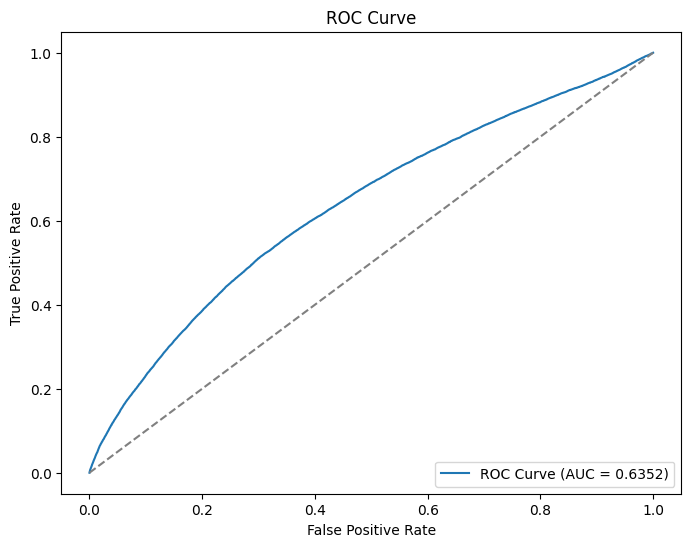

Threshold analysis (targeting high precision):
Threshold: 0.30 -> Precision: 0.158, Recall: 1.000, F0.5: 0.190
Threshold: 0.35 -> Precision: 0.348, Recall: 0.123, F0.5: 0.255
Selected threshold based on highest precision: 0.35 (Precision: 0.348, Recall: 0.123, F0.5: 0.255)
Final Test Accuracy: 0.8252053960847956

Final Classification Report (using threshold 0.35):
              precision    recall  f1-score   support

           0       0.85      0.96      0.90    166062
           1       0.35      0.12      0.18     31118

    accuracy                           0.83    197180
   macro avg       0.60      0.54      0.54    197180
weighted avg       0.77      0.83      0.79    197180

Percentage of predicted growth (2*fee) that is incorrect: 65.22%
Ratio of actual growth events correctly predicted: 12.29%

Top 20 Feature Importances:
                feature  importance
69             volume_y   20.208344
102        MOM_ATR_LT_y    6.137392
100        MOM_ATR_ST_y    5.811125
112      B

In [15]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    fbeta_score
)
import matplotlib.pyplot as plt

# --------------------------
# Parameters and Threshold Conversion
# --------------------------
fee = 5  # Fee in basis points
threshold_return = (2 * fee) / 10000  # e.g. fee=5 -> threshold_return = 0.001

# --------------------------
# Data Preparation
# --------------------------
# Assuming 'df' is your DataFrame with technical indicators and a 'close_y' column.
df['target'] = ((df['close_y'].shift(-1) / df['close_y'] - 1) > threshold_return).astype(int)
df.dropna(inplace=True)

# Define features (exclude 'close_y' and 'target')
features = [col for col in df.columns if col not in ['date', 'target']]
X = df[features]
y = df['target']

# --------------------------
# Train/Test Split (Time-Ordered)
# --------------------------
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size].copy(), X.iloc[train_size:].copy()
y_train, y_test = y.iloc[:train_size].copy(), y.iloc[train_size:].copy()

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# --------------------------
# Adjust Class Weights to Reduce False Positives
# --------------------------
# In our context, we want to be cautious about predicting growth ("buy" signals).
# Lowering the weight for class 1 (growth) means misclassifying a growth event costs less
# compared to misclassifying a non-growth event. The effect is that the model becomes
# more conservative—predicting class 1 only when it's very sure.
manual_class_weights = [1, 0.3]
print("Using manual class weights:", manual_class_weights)

# --------------------------
# Model Initialization and Training
# --------------------------
# Increase iterations and depth with a low learning rate to allow more detailed training.
model = CatBoostClassifier(
    iterations=1000,             # More iterations to allow proper convergence
    learning_rate=0.005,         # Lower learning rate for gradual learning
    depth=8,                     # Greater depth for more complex splits
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    od_type='Iter',
    od_wait=100,
    class_weights=manual_class_weights
    # Uncomment below if using a GPU:
    # task_type='GPU'
)

model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=100,
    verbose=100
)

# --------------------------
# Model Evaluation: ROC & AUC
# --------------------------
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)
print('Test ROC AUC: {:.4f}'.format(roc_auc_value))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# --------------------------
# Threshold Tuning with a Focus on High Precision
# --------------------------
print("Threshold analysis (targeting high precision):")
# We now scan over candidate thresholds in a range where the predicted probability might yield fewer positives.
candidates = np.arange(0.3, 0.9, 0.05)
results = []
for thresh in candidates:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    if np.sum(y_pred_thresh) == 0:  # Skip thresholds that yield no positives.
        continue
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh, zero_division=0)
    # F0.5 score gives extra weight to precision.
    f05 = fbeta_score(y_test, y_pred_thresh, beta=0.5, zero_division=0)
    results.append((thresh, prec, rec, f05))
    print(f"Threshold: {thresh:.2f} -> Precision: {prec:.3f}, Recall: {rec:.3f}, F0.5: {f05:.3f}")

if results:
    # Here, select the threshold that yields the highest precision among candidates.
    best_thresh, best_prec, best_rec, best_f05 = max(results, key=lambda x: x[1])
    print(f"Selected threshold based on highest precision: {best_thresh:.2f} "
          f"(Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F0.5: {best_f05:.3f})")
else:
    best_thresh = 0.5
    print("No candidate threshold produced any positives; defaulting to 0.5.")

# --------------------------
# Final Evaluation with Selected Threshold
# --------------------------
y_pred_final = (y_pred_proba >= best_thresh).astype(int)
final_accuracy = accuracy_score(y_test, y_pred_final)
print("Final Test Accuracy:", final_accuracy)
print("\nFinal Classification Report (using threshold {:.2f}):".format(best_thresh))
print(classification_report(y_test, y_pred_final, zero_division=0))

# --------------------------
# Print Additional Metrics: Incorrect and Correct Predictions for Growth (class 1)
# --------------------------
# Count true positives (TP), false positives (FP), false negatives (FN)
TP = np.sum((y_pred_final == 1) & (y_test == 1))
FP = np.sum((y_pred_final == 1) & (y_test == 0))
predicted_positives = np.sum(y_pred_final == 1)
actual_positives = np.sum(y_test == 1)

if predicted_positives > 0:
    pct_incorrect_growth = (FP / predicted_positives) * 100
else:
    pct_incorrect_growth = float('nan')

if actual_positives > 0:
    ratio_correctly_predicted_growth = (TP / actual_positives) * 100
else:
    ratio_correctly_predicted_growth = float('nan')

print(f"Percentage of predicted growth (2*fee) that is incorrect: {pct_incorrect_growth:.2f}%")
print(f"Ratio of actual growth events correctly predicted: {ratio_correctly_predicted_growth:.2f}%")

# --------------------------
# Feature Importance (Optional)
# --------------------------
feature_importances = model.get_feature_importance(train_pool)
feat_imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print("\nTop 20 Feature Importances:")
print(feat_imp_df.head(20))